The code to process Adult Census data, edit/train models, and perform adversarial debiasing. 

Necessary libraries for the notebook.

In [1]:
import os
import tensorflow as tf
import tf2onnx
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.utils import to_categorical
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.onnx
from scipy.io import savemat
import csv

2024-07-19 15:10:46.356964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 15:10:47.236003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data Preprocessing

In [12]:
def load_bank():
    # Define paths and column names
    file_path = '../data/bank/bank-additional-full.csv'
    column_names = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 
                    'month', 'day_of_week', 'duration', 'emp.var.rate', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
    na_values = ['unknown']
    
    # Load data
    df = pd.read_csv(file_path, sep=';', na_values=na_values)
    
    # Drop na values
    df.dropna(inplace=True)
    
    # Encode categorical features
    categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    for col in categorical_features:
        df[col] = LabelEncoder().fit_transform(df[col])
    
    # Binary transformation for age (1 if age >= 25, else 0)
    df['age'] = df['age'].apply(lambda x: 1 if x >= 25 else 0)
    
    # Convert target variable to binary
    df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
    
    # Select columns to keep (including the target variable 'y')
    df = df[column_names]
    
    # Split features and labels
    X = df.drop('y', axis=1)
    y = df['y']
    
    # Normalize features
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    # Extract the protected attribute ('age' for demonstration, adjust as needed)
    protected_attribute = X[:, df.columns.get_loc('age')]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(
        X, to_categorical(y, num_classes=2), protected_attribute, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, protected_train, protected_test

# Saves data for use in verification
def load_and_save_bank_data():
    X_train, X_test, y_train, y_test, _, _ = load_bank()
    
    # Scaling numerical features with MinMaxScaler
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Prepare data dictionary to save as .mat file
    data_dict = {
        'X': X_test, 
        'y': y_test   
    }
    
    # Save to .mat file for use in MATLAB
    savemat("./processed_data/bank_data.mat", data_dict)
    print("Data saved to bank_data.mat")

    return X_train, X_test, y_train, y_test

### Model Editing

Method to save the models as onnx files for verification. 

In [13]:
# Function to save the model as ONNX format
def save_model_onnx(model, input_shape, onnx_file_path):
    # Create a dummy input tensor with the correct input shape (batch_size, input_shape)
    dummy_input = tf.random.normal([1] + list(input_shape))

    # Convert the model to ONNX
    model_proto, external_tensor_storage = tf2onnx.convert.from_keras(model, 
                                                                      input_signature=(tf.TensorSpec(shape=[None] + list(input_shape), dtype=tf.float32),),
                                                                      opset=13)
    
    # Save the ONNX model to the specified path
    with open(onnx_file_path, "wb") as f:
        f.write(model_proto.SerializeToString())
    
    print(f"Model has been saved in ONNX format at {onnx_file_path}")

Change the models so they are able to be used in FairNNV. FairNNV cannot handle sigmoid so shift to softmax and adjust final layers. 

In [14]:
# Function to modify a model for multiclass classification
def modify_model_for_multiclass(model_path, num_classes):
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore", category=UserWarning)
    model = load_model(model_path)

    # Create a new input layer with the correct shape
    new_input = tf.keras.layers.Input(shape=(16,))
    x = new_input

    # Transfer the layers except the last one
    for layer in model.layers[:-1]:
        x = layer(x)

    # Create a new output layer
    output = tf.keras.layers.Dense(num_classes, activation='softmax', name='new_output')(x)
    
    # Create a new model
    new_model = tf.keras.models.Model(inputs=new_input, outputs=output)
    
    return new_model

# Ensure the save directories exist
model_dir = './bank/bank_h5'
save_dir = './bank/bank_keras'
onnx_save_dir = './bank/bank_onnx'
num_classes = 2

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(onnx_save_dir):
    os.makedirs(onnx_save_dir)

# Modify each model in the directory to remove sigmoid
for model_file in os.listdir(model_dir):
    if model_file.endswith('.h5'):
        model_path = os.path.join(model_dir, model_file)
        new_model = modify_model_for_multiclass(model_path, num_classes)
        
        # Update the model's loss function
        new_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Save the modified model
        save_path = os.path.join(save_dir, model_file.replace('.h5', '.keras'))
        new_model.save(save_path)


/home/annemtumlin/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/annemtumlin/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Re-train models. 

In [15]:
# Load and preprocess the Bank dataset
X_train, X_test, y_train, y_test = load_and_save_bank_data()

for model_file in os.listdir(save_dir):
    if model_file.endswith('.keras'):
        model_path = os.path.join(save_dir, model_file)
        
        try:
            # Load the modified model
            print(f"Loading model {model_file}")
            # with warnings.catch_warnings():
            #     warnings.simplefilter("ignore", category=UserWarning)
            model = load_model(model_path)

            # Reinitialize the optimizer
            model.compile(
                optimizer=Adam(),
                loss='categorical_crossentropy', 
                metrics=['accuracy']
            )

            # Fit the model
            print(f"Training model {model_file}")
            history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

            # Evaluate the model
            y_pred = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)
            accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)

            print(f"Model {model_file} - Accuracy: {accuracy}")

            # Save the retrained model
            model.save(model_path)
            print(f"Model {model_file} retrained and saved successfully.")

            # Save the model as ONNX
            onnx_save_path = os.path.join(onnx_save_dir, model_file.replace('.keras', '.onnx'))
            save_model_onnx(model, (16,), onnx_save_path)

        except Exception as e:
            print(f"Failed to process {model_file}. Error: {e}")

Data saved to bank_data.mat
Loading model BM-7.keras
Training model BM-7.keras
Epoch 1/50


/home/annemtumlin/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8619 - loss: 0.3433 - val_accuracy: 0.8784 - val_loss: 0.3261
Epoch 2/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8806 - loss: 0.3161 - val_accuracy: 0.8831 - val_loss: 0.2977
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8929 - loss: 0.2735 - val_accuracy: 0.8872 - val_loss: 0.2645
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8927 - loss: 0.2519 - val_accuracy: 0.8913 - val_loss: 0.2511
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9012 - loss: 0.2335 - val_accuracy: 0.8899 - val_loss: 0.2492
Epoch 6/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8999 - loss: 0.2295 - val_accuracy: 0.8899 - val_loss: 0.2496
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9009 - loss: 0.2272 - val_accuracy: 0.8879 - val_loss: 0.2556
Epoch 8/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9005 - loss: 0.2262 - val_accuracy: 0.8932 - val_

2024-07-19 15:53:01.129250: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:53:01.129352: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-19 15:53:01.151177: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:53:01.151320: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
/home/annemtumlin/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8723 - loss: 0.5038 - val_accuracy: 0.8713 - val_loss: 0.3396
Epoch 2/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8722 - loss: 0.3325 - val_accuracy: 0.8713 - val_loss: 0.3324
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8757 - loss: 0.3247 - val_accuracy: 0.8694 - val_loss: 0.3265
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8731 - loss: 0.3227 - val_accuracy: 0.8700 - val_loss: 0.3235
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8742 - loss: 0.3179 - val_accuracy: 0.8774 - val_loss: 0.3171
Epoch 6/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8789 - loss: 0.3156 - val_accuracy: 0.8784 - val_loss: 0.3127
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8824 - loss: 0.3060 - val_accuracy: 0.8823 - val_loss: 0.3095
Epoch 8/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8844 - loss: 0.3022 - val_accuracy: 0.8829 - val_

2024-07-19 15:53:36.744539: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:53:36.744705: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-19 15:53:36.770696: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:53:36.770839: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
/home/annemtumlin/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7303 - loss: 0.7644 - val_accuracy: 0.8713 - val_loss: 0.3808
Epoch 2/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8776 - loss: 0.3630 - val_accuracy: 0.8713 - val_loss: 0.3613
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8778 - loss: 0.3453 - val_accuracy: 0.8713 - val_loss: 0.3444
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8765 - loss: 0.3310 - val_accuracy: 0.8713 - val_loss: 0.3256
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8746 - loss: 0.3126 - val_accuracy: 0.8741 - val_loss: 0.3082
Epoch 6/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8837 - loss: 0.2930 - val_accuracy: 0.8825 - val_loss: 0.2903
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8888 - loss: 0.2766 - val_accuracy: 0.8848 - val_loss: 0.2705
Epoch 8/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8943 - loss: 0.2523 - val_accuracy: 0.8864 - val_

2024-07-19 15:54:12.864168: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:54:12.864261: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-19 15:54:12.894691: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:54:12.894814: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
/home/annemtumlin/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8771 - loss: 1.0317 - val_accuracy: 0.8713 - val_loss: 0.3451
Epoch 2/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8774 - loss: 0.3322 - val_accuracy: 0.8713 - val_loss: 0.3326
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8742 - loss: 0.3233 - val_accuracy: 0.8713 - val_loss: 0.3221
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8757 - loss: 0.3064 - val_accuracy: 0.8713 - val_loss: 0.3087
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8722 - loss: 0.2992 - val_accuracy: 0.8854 - val_loss: 0.2847
Epoch 6/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8931 - loss: 0.2616 - val_accuracy: 0.8875 - val_loss: 0.2542
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8960 - loss: 0.2319 - val_accuracy: 0.8879 - val_loss: 0.2487
Epoch 8/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8959 - loss: 0.2379 - val_accuracy: 0.8780 - val_

2024-07-19 15:54:56.512632: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:54:56.512773: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-19 15:54:56.551765: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:54:56.551870: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
/home/annemtumlin/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7391 - loss: 0.9212 - val_accuracy: 0.8764 - val_loss: 0.3294
Epoch 2/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8815 - loss: 0.3146 - val_accuracy: 0.8850 - val_loss: 0.2902
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8936 - loss: 0.2596 - val_accuracy: 0.8885 - val_loss: 0.2588
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8968 - loss: 0.2383 - val_accuracy: 0.8875 - val_loss: 0.2618
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8979 - loss: 0.2318 - val_accuracy: 0.8899 - val_loss: 0.2494
Epoch 6/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9003 - loss: 0.2248 - val_accuracy: 0.8918 - val_loss: 0.2430
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8985 - loss: 0.2307 - val_accuracy: 0.8905 - val_loss: 0.2438
Epoch 8/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8946 - loss: 0.2271 - val_accuracy: 0.8911 - val_

2024-07-19 15:55:42.786432: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:55:42.786522: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-19 15:55:42.818322: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:55:42.818423: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
/home/annemtumlin/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6164 - loss: 2.1814 - val_accuracy: 0.8768 - val_loss: 0.3054
Epoch 2/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8895 - loss: 0.2856 - val_accuracy: 0.8854 - val_loss: 0.2757
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - accuracy: 0.8935 - loss: 0.2588 - val_accuracy: 0.8889 - val_loss: 0.2634
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8937 - loss: 0.2473 - val_accuracy: 0.8893 - val_loss: 0.2545
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8951 - loss: 0.2425 - val_accuracy: 0.8903 - val_loss: 0.2599
Epoch 6/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8973 - loss: 0.2350 - val_accuracy: 0.8907 - val_loss: 0.2539
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8986 - loss: 0.2356 - val_accuracy: 0.8885 - val_loss: 0.2487
Epoch 8/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8955 - loss: 0.2344 - val_accuracy: 0.8913 - va

2024-07-19 15:56:20.287058: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:56:20.287149: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-19 15:56:20.306438: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:56:20.306528: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
/home/annemtumlin/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8406 - loss: 0.6006 - val_accuracy: 0.8676 - val_loss: 0.3525
Epoch 2/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8765 - loss: 0.3296 - val_accuracy: 0.8797 - val_loss: 0.2976
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8851 - loss: 0.2897 - val_accuracy: 0.8854 - val_loss: 0.2814
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8887 - loss: 0.2714 - val_accuracy: 0.8852 - val_loss: 0.2789
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8900 - loss: 0.2608 - val_accuracy: 0.8883 - val_loss: 0.2584
Epoch 6/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8947 - loss: 0.2511 - val_accuracy: 0.8897 - val_loss: 0.2570
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8997 - loss: 0.2380 - val_accuracy: 0.8907 - val_loss: 0.2533
Epoch 8/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8903 - loss: 0.2487 - val_accuracy: 0.8893 - val_

2024-07-19 15:56:57.261902: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:56:57.261989: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-19 15:56:57.282848: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:56:57.282965: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
/home/annemtumlin/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8654 - loss: 2.1468 - val_accuracy: 0.8692 - val_loss: 0.3443
Epoch 2/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8722 - loss: 0.3309 - val_accuracy: 0.8711 - val_loss: 0.3337
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8762 - loss: 0.3210 - val_accuracy: 0.8729 - val_loss: 0.3282
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8829 - loss: 0.3106 - val_accuracy: 0.8745 - val_loss: 0.3195
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8797 - loss: 0.3073 - val_accuracy: 0.8793 - val_loss: 0.3069
Epoch 6/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8880 - loss: 0.2880 - val_accuracy: 0.8838 - val_loss: 0.2779
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8877 - loss: 0.2678 - val_accuracy: 0.8881 - val_loss: 0.2565
Epoch 8/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8930 - loss: 0.2405 - val_accuracy: 0.8823 - val_

2024-07-19 15:57:35.946426: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:57:35.946526: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-19 15:57:35.970757: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-19 15:57:35.970968: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


### Adversairal Debiasing 

In [16]:
# To determine which adversarial debiasing framework to run to collect results
multiple_runs = False
singular_run = True

In [17]:
# function to save model metrics to csv
def save_metrics_to_csv(filename, model_file, model_name, classification_accuracy, balanced_accuracy, disparate_impact, equal_opportunity_difference, average_odds_difference,precision,recall,f1):
    # Check if the file exists to write the header only once
    file_exists = os.path.isfile(filename)

    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            # Write the header if the file does not exist
            writer.writerow(['Model File', 'Model', 'Classification Accuracy', 'Balanced Accuracy', 'Disparate Impact', 'Equal Opportunity Difference', 'Average Odds Difference', 'Precision', 'Recall','F1'])
        
        # Write the metrics
        writer.writerow([model_file, model_name, classification_accuracy, balanced_accuracy, disparate_impact, equal_opportunity_difference, average_odds_difference, precision, recall, f1])

# function to save the mean/std dev of model metrics for multiple runs to csv
def save_metrics_to_csv_mr(filename, model_name, model_type, means, stds):
    headers = [
        'model_name', 'model_type', 'metric', 'mean', 'std_dev'
    ]
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if os.path.getsize(filename) == 0:
            writer.writerow(headers)
        for metric, mean_value in means.items():
            writer.writerow([model_name, model_type, metric, mean_value, stds[metric]])

Various metrics for evaluation including accuracy and fairness.

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Metrics calculation functions
def precision(y_true, y_pred, average='binary'):
    return precision_score(y_true, y_pred, average=average)

def recall(y_true, y_pred, average='binary'):
    return recall_score(y_true, y_pred, average=average)

def f1(y_true, y_pred, average='binary'):
    return f1_score(y_true, y_pred, average=average)

def classification_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def balanced_accuracy(y_true, y_pred):
    classes = np.unique(y_true)
    recall_scores = []
    for cls in classes:
        true_positives = np.sum((y_true == cls) & (y_pred == cls))
        possible_positives = np.sum(y_true == cls)
        recall_scores.append(true_positives / possible_positives)
    return np.mean(recall_scores)

def disparate_impact(y_true, y_pred, protected_attribute):
    privileged = protected_attribute == 1
    unprivileged = protected_attribute == 0
    if np.sum(privileged) == 0 or np.sum(unprivileged) == 0:
        return np.nan
    privileged_outcome = np.mean(y_pred[privileged]) if np.sum(privileged) > 0 else np.nan
    unprivileged_outcome = np.mean(y_pred[unprivileged]) if np.sum(unprivileged) > 0 else np.nan
    if privileged_outcome == 0:
        return np.nan  
    return unprivileged_outcome / privileged_outcome

def equal_opportunity_difference(y_true, y_pred, protected_attribute):
    privileged = protected_attribute == 1
    unprivileged = protected_attribute == 0
    true_positive_rate_privileged = np.sum((y_true[privileged] == 1) & (y_pred[privileged] == 1)) / np.sum(y_true[privileged] == 1)
    true_positive_rate_unprivileged = np.sum((y_true[unprivileged] == 1) & (y_pred[unprivileged] == 1)) / np.sum(y_true[unprivileged] == 1)
    return true_positive_rate_unprivileged - true_positive_rate_privileged

def average_odds_difference(y_true, y_pred, protected_attribute):
    privileged = protected_attribute == 1
    unprivileged = protected_attribute == 0
    tpr_privileged = np.sum((y_true[privileged] == 1) & (y_pred[privileged] == 1)) / np.sum(y_true[privileged] == 1)
    tpr_unprivileged = np.sum((y_true[unprivileged] == 1) & (y_pred[unprivileged] == 1)) / np.sum(y_true[unprivileged] == 1)
    fpr_privileged = np.sum((y_true[privileged] == 0) & (y_pred[privileged] == 1)) / np.sum(y_true[privileged] == 0)
    fpr_unprivileged = np.sum((y_true[unprivileged] == 0) & (y_pred[unprivileged] == 1)) / np.sum(y_true[unprivileged] == 0)
    average_odds_privileged = (tpr_privileged + fpr_privileged) / 2
    average_odds_unprivileged = (tpr_unprivileged + fpr_unprivileged) / 2
    return average_odds_unprivileged - average_odds_privileged

Define the adversarial model. 

In [19]:
# Adversary model definition
def build_adversary_model(input_shape):
    adversary_input = layers.Input(shape=input_shape)
    x = layers.Dense(64, activation='relu')(adversary_input)
    x = layers.Dense(32, activation='relu')(x)
    adversary_output = layers.Dense(1, activation='sigmoid')(x)
    adversary_model = models.Model(inputs=adversary_input, outputs=adversary_output)
    adversary_model.compile(optimizer='adam', loss='binary_crossentropy')
    return adversary_model

The code to generate results on one run of the adversarial debiasing model. 
Also, there is provided functionality to view the accuracy/loss to evaluate overfitting versus underfitting.

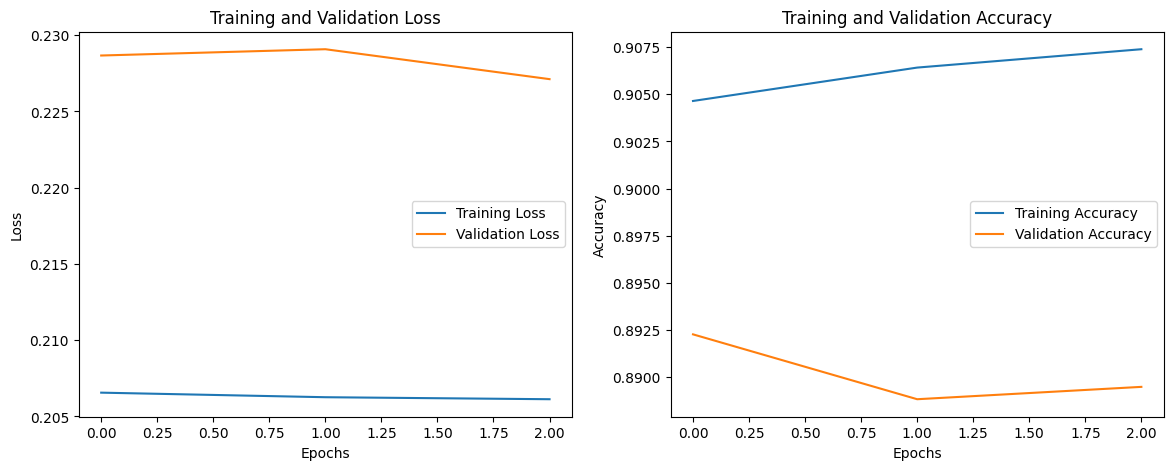

KeyboardInterrupt: 

In [20]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.callbacks import EarlyStopping

if singular_run:
    # Load and preprocess the data
    X_train, X_test, y_train, y_test, protected_train, protected_test = load_bank()

    # Standardize the features
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Directory paths
    input_directory = './bank/bank_keras'
    output_directory = './bank/bank_debiased_onnx'

    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    metrics_filename = './model_metrics/bank_model_metrics.csv'

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    # Iterate over all .keras files in the input directory to convert to ONNX file
    for file in os.listdir(input_directory):
        if file.endswith('.keras'):
            # Full path to the current model file
            input_path = os.path.join(input_directory, file)
            output_path = os.path.join(output_directory, file.replace('.keras', '.onnx'))

            try:
                # Load the model
                print(f"Loading model from {input_path}")
                classifier_model = load_model(input_path)

                # Ensure the model is compiled with the correct optimizer and metrics
                classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

                # Print metrics for plain model
                y_test_pred_plain = classifier_model.predict(X_test).argmax(axis=1)
                y_test_true = y_test.argmax(axis=1)

                plain_classification_accuracy = classification_accuracy(y_test_true, y_test_pred_plain)
                plain_balanced_accuracy = balanced_accuracy(y_test_true, y_test_pred_plain)
                plain_disparate_impact = disparate_impact(y_test_true, y_test_pred_plain, protected_test)
                plain_equal_opportunity_difference = equal_opportunity_difference(y_test_true, y_test_pred_plain, protected_test)
                plain_average_odds_difference = average_odds_difference(y_test_true, y_test_pred_plain, protected_test)
                plain_precision = precision(y_test_true, y_test_pred_plain, average='macro')  # Use 'macro' for multi-class
                plain_recall = recall(y_test_true, y_test_pred_plain, average='macro')        # Use 'macro' for multi-class
                plain_f1 = f1(y_test_true, y_test_pred_plain, average='macro')                # Use 'macro' for multi-class

                save_metrics_to_csv(metrics_filename, file, 'Plain Model', plain_classification_accuracy, plain_balanced_accuracy, plain_disparate_impact, plain_equal_opportunity_difference, plain_average_odds_difference, plain_precision, plain_recall, plain_f1)
                
                # Build and compile the adversary model
                adversary_model = build_adversary_model(classifier_model.output_shape[1:])
                
                # Initialize lists to store metrics
                train_losses = []
                val_losses = []
                train_accuracies = []
                val_accuracies = []

                # Training parameters
                num_epochs = 500
                batch_size = 128
                initial_learning_rate = 0.001
                adversary_loss_weight_initial = 0.1
                adversary_loss_weight_final = 0.7

                # Optimizers
                classifier_optimizer = tf.keras.optimizers.Adam(initial_learning_rate)
                adversary_optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

                # Learning rate scheduler
                lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate,
                    decay_steps=10000,
                    decay_rate=0.96,
                    staircase=True
                )

                # Update the optimizer to use the learning rate scheduler
                classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
                adversary_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

                # Loss functions
                classification_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
                adversary_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

                # Training loop
                best_val_loss = float('inf')
                epochs_since_best = 0

                # Training loop
                for epoch in range(num_epochs):
                    # Shuffle the training data
                    indices = np.arange(X_train.shape[0])
                    np.random.shuffle(indices)

                    # Mini-batch training
                    epoch_train_loss = 0
                    epoch_train_accuracy = 0
                    num_batches = 0
                    for start in range(0, X_train.shape[0], batch_size):
                        end = min(start + batch_size, X_train.shape[0])
                        batch_indices = indices[start:end]

                        X_batch = X_train[batch_indices]
                        y_batch = y_train[batch_indices]
                        protected_batch = protected_train[batch_indices].reshape(-1, 1)

                        with tf.GradientTape(persistent=True) as tape:
                            # Forward pass through the classifier
                            classifier_predictions = classifier_model(X_batch, training=True)

                            # Forward pass through the adversary with no gradient accumulation
                            adversary_predictions = adversary_model(classifier_predictions, training=False)

                            # Compute losses
                            classification_loss = classification_loss_fn(y_batch, classifier_predictions)
                            adversary_loss = adversary_loss_fn(protected_batch, adversary_predictions)

                            # Linearly increase the adversary loss weight over epochs
                            adversary_loss_weight = adversary_loss_weight_initial + \
                                                    (adversary_loss_weight_final - adversary_loss_weight_initial) * (epoch / num_epochs)

                            total_loss = classification_loss - adversary_loss_weight * adversary_loss

                        # Compute gradients and update classifier weights
                        classifier_gradients = tape.gradient(total_loss, classifier_model.trainable_variables)
                        classifier_optimizer.apply_gradients(zip(classifier_gradients, classifier_model.trainable_variables))

                        with tape:
                            # Forward pass through the classifier
                            classifier_predictions = classifier_model(X_batch, training=True)

                            # Forward pass through the adversary
                            adversary_predictions = adversary_model(classifier_predictions, training=True)

                            # Compute adversary loss
                            adversary_loss = adversary_loss_fn(protected_batch, adversary_predictions)

                        # Compute gradients and update adversary weights
                        adversary_vars = [var for var in adversary_model.trainable_variables]
                        adversary_gradients = tape.gradient(adversary_loss, adversary_vars)
                        adversary_optimizer.apply_gradients(zip(adversary_gradients, adversary_vars))

                        # Accumulate training loss and accuracy
                        epoch_train_loss += classification_loss.numpy()
                        epoch_train_accuracy += np.mean(np.argmax(classifier_predictions, axis=1) == np.argmax(y_batch, axis=1))
                        num_batches += 1

                    # Calculate average training loss and accuracy
                    epoch_train_loss /= num_batches
                    epoch_train_accuracy /= num_batches

                    # Evaluate on validation set
                    val_predictions = classifier_model.predict(X_test)
                    val_loss = classification_loss_fn(y_test, val_predictions).numpy()
                    val_accuracy = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(y_test, axis=1))

                    # Store metrics
                    train_losses.append(epoch_train_loss)
                    val_losses.append(val_loss)
                    train_accuracies.append(epoch_train_accuracy)
                    val_accuracies.append(val_accuracy)

                    # Real-time plotting
                    clear_output(wait=True)
                    plt.figure(figsize=(14, 5))
                    plt.subplot(1, 2, 1)
                    plt.plot(train_losses, label='Training Loss')
                    plt.plot(val_losses, label='Validation Loss')
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.legend()
                    plt.title('Training and Validation Loss')

                    plt.subplot(1, 2, 2)
                    plt.plot(train_accuracies, label='Training Accuracy')
                    plt.plot(val_accuracies, label='Validation Accuracy')
                    plt.xlabel('Epochs')
                    plt.ylabel('Accuracy')
                    plt.legend()
                    plt.title('Training and Validation Accuracy')

                    plt.show()

                # print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss}, Validation Loss: {val_loss}, Train Accuracy: {epoch_train_accuracy}, Validation Accuracy: {val_accuracy}, Adversary Loss Weight: {adversary_loss_weight}")

                # Early stopping check
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        epochs_since_best = 0
                    else:
                        epochs_since_best += 1
                        if epochs_since_best >= early_stopping.patience:
                            print(f"Early stopping at epoch {epoch + 1}")
                            break

                # Predictions for debiased model
                y_test_pred_debiased = classifier_model.predict(X_test).argmax(axis=1)

                debiased_classification_accuracy = classification_accuracy(y_test_true, y_test_pred_debiased)
                debiased_balanced_accuracy = balanced_accuracy(y_test_true, y_test_pred_debiased)
                debiased_disparate_impact = disparate_impact(y_test_true, y_test_pred_debiased, protected_test)
                debiased_equal_opportunity_difference = equal_opportunity_difference(y_test_true, y_test_pred_debiased, protected_test)
                debiased_average_odds_difference = average_odds_difference(y_test_true, y_test_pred_debiased, protected_test)
                debiased_precision = precision(y_test_true, y_test_pred_plain, average='macro')  # Use 'macro' for multi-class
                debiased_recall = recall(y_test_true, y_test_pred_plain, average='macro')        # Use 'macro' for multi-class
                debiased_f1 = f1(y_test_true, y_test_pred_plain, average='macro')                # Use 'macro' for multi-class

                save_metrics_to_csv(metrics_filename, file, 'Debiased Model', debiased_classification_accuracy, debiased_balanced_accuracy, debiased_disparate_impact, debiased_equal_opportunity_difference, debiased_average_odds_difference, debiased_precision, debiased_recall, debiased_f1)
                
                # Save the debiased model as ONNX
                input_shape = (20,)  # Adjust the input shape based on your model's expected input
                save_model_onnx(classifier_model, input_shape, output_path)

            except Exception as e:
                print(f"Failed to convert {file}. Error: {e}")


## Adversarial Debiasing Process For Multiple Runs

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.callbacks import EarlyStopping

if multiple_runs:
    # Load and preprocess the data
    X_train, X_test, y_train, y_test, protected_train, protected_test = load_bank()

    # Standardize the features
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Directory paths
    input_directory = './bank/bank_keras'
    output_directory = './bank/bank_debiased_onnx'

    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    metrics_filename = './model_metrics/bank_model_metrics_multiple_runs.csv'

    # Number of runs
    num_runs = 10

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)

    # Iterate over all .keras files in the input directory to convert to ONNX file
    for file in os.listdir(input_directory):
        if file.endswith('.keras'):
            # Full path to the current model file
            input_path = os.path.join(input_directory, file)
            output_path = os.path.join(output_directory, file.replace('.keras', '.onnx'))

            try:
                plain_metrics = {
                    'classification_accuracy': [],
                    'balanced_accuracy': [],
                    'disparate_impact': [],
                    'equal_opportunity_difference': [],
                    'average_odds_difference': [],
                    'precision': [],
                    'recall': [],
                    'f1': []
                }

                debiased_metrics = {
                    'classification_accuracy': [],
                    'balanced_accuracy': [],
                    'disparate_impact': [],
                    'equal_opportunity_difference': [],
                    'average_odds_difference': [],
                    'precision': [],
                    'recall': [],
                    'f1': []
                }
            
                # Inside the loop for each .keras file
                for run in range(num_runs):
                    print(f"Run {run + 1}/{num_runs}")

                    # Random seed for variability
                    np.random.seed(run)
                    tf.random.set_seed(run)

                    # Shuffle the training data
                    indices = np.arange(X_train.shape[0])
                    np.random.shuffle(indices)
                    X_train_shuffled = X_train[indices]
                    y_train_shuffled = y_train[indices]
                    protected_train_shuffled = protected_train[indices]

                    # Load the model
                    classifier_model = load_model(input_path)

                    # Compile the model
                    classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

                    # Train the model with shuffled data
                    classifier_model.fit(X_train_shuffled, y_train_shuffled, epochs=10, batch_size=128, verbose=0)

                    # Train and evaluate the plain model
                    y_test_pred_plain = classifier_model.predict(X_test).argmax(axis=1)
                    y_test_true = y_test.argmax(axis=1)

                    plain_metrics['classification_accuracy'].append(classification_accuracy(y_test_true, y_test_pred_plain))
                    plain_metrics['balanced_accuracy'].append(balanced_accuracy(y_test_true, y_test_pred_plain))
                    plain_metrics['disparate_impact'].append(disparate_impact(y_test_true, y_test_pred_plain, protected_test))
                    plain_metrics['equal_opportunity_difference'].append(equal_opportunity_difference(y_test_true, y_test_pred_plain, protected_test))
                    plain_metrics['average_odds_difference'].append(average_odds_difference(y_test_true, y_test_pred_plain, protected_test))
                    plain_metrics['precision'].append(precision_score(y_test_true, y_test_pred_plain, average='macro', zero_division=1))
                    plain_metrics['recall'].append(recall_score(y_test_true, y_test_pred_plain, average='macro'))
                    plain_metrics['f1'].append(f1_score(y_test_true, y_test_pred_plain, average='macro'))

                    # Build and compile the adversary model
                    adversary_model = build_adversary_model(classifier_model.output_shape[1:])

                    # Training parameters
                    num_epochs = 500
                    batch_size = 128
                    initial_learning_rate = 0.001
                    adversary_loss_weight_initial = 0.1
                    adversary_loss_weight_final = 0.7

                    # Optimizers
                    classifier_optimizer = tf.keras.optimizers.Adam(initial_learning_rate)
                    adversary_optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

                    # Learning rate scheduler
                    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                        initial_learning_rate,
                        decay_steps=10000,
                        decay_rate=0.96,
                        staircase=True
                    )

                    # Update the optimizer to use the learning rate scheduler
                    classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
                    adversary_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

                    # Loss functions
                    classification_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
                    adversary_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

                    best_val_loss = float('inf')
                    epochs_since_best = 0

                    # Training loop
                    for epoch in range(num_epochs):
                        # Shuffle the training data
                        indices = np.arange(X_train.shape[0])
                        np.random.shuffle(indices)

                        # Mini-batch training
                        epoch_train_loss = 0
                        epoch_train_accuracy = 0
                        num_batches = 0
                        for start in range(0, X_train.shape[0], batch_size):
                            end = min(start + batch_size, X_train.shape[0])
                            batch_indices = indices[start:end]

                            X_batch = X_train[batch_indices]
                            y_batch = y_train[batch_indices]
                            protected_batch = protected_train[batch_indices].reshape(-1, 1)

                            with tf.GradientTape(persistent=True) as tape:
                                # Forward pass through the classifier
                                classifier_predictions = classifier_model(X_batch, training=True)

                                # Forward pass through the adversary with no gradient accumulation
                                adversary_predictions = adversary_model(classifier_predictions, training=False)

                                # Compute losses
                                classification_loss = classification_loss_fn(y_batch, classifier_predictions)
                                adversary_loss = adversary_loss_fn(protected_batch, adversary_predictions)

                                # Linearly increase the adversary loss weight over epochs
                                adversary_loss_weight = adversary_loss_weight_initial + \
                                                        (adversary_loss_weight_final - adversary_loss_weight_initial) * (epoch / num_epochs)

                                total_loss = classification_loss - adversary_loss_weight * adversary_loss

                            # Compute gradients and update classifier weights
                            classifier_gradients = tape.gradient(total_loss, classifier_model.trainable_variables)
                            classifier_optimizer.apply_gradients(zip(classifier_gradients, classifier_model.trainable_variables))

                            with tape:
                                # Forward pass through the classifier
                                classifier_predictions = classifier_model(X_batch, training=True)

                                # Forward pass through the adversary
                                adversary_predictions = adversary_model(classifier_predictions, training=True)

                                # Compute adversary loss
                                adversary_loss = adversary_loss_fn(protected_batch, adversary_predictions)

                            # Compute gradients and update adversary weights
                            adversary_vars = [var for var in adversary_model.trainable_variables]
                            adversary_gradients = tape.gradient(adversary_loss, adversary_vars)
                            adversary_optimizer.apply_gradients(zip(adversary_gradients, adversary_vars))

                            # Accumulate training loss and accuracy
                            epoch_train_loss += classification_loss.numpy()
                            epoch_train_accuracy += np.mean(np.argmax(classifier_predictions, axis=1) == np.argmax(y_batch, axis=1))
                            num_batches += 1

                        print(f"Epoch {epoch + 1}/{num_epochs}, Classification Loss: {classification_loss.numpy()}, Adversary Loss: {adversary_loss.numpy()}")

                        # Calculate average training loss and accuracy
                        epoch_train_loss /= num_batches
                        epoch_train_accuracy /= num_batches

                        # Evaluate on validation set
                        val_predictions = classifier_model.predict(X_test)
                        val_loss = classification_loss_fn(y_test, val_predictions).numpy()
                        val_accuracy = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(y_test, axis=1))

                        # Early stopping check
                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                            epochs_since_best = 0
                        else:
                            epochs_since_best += 1
                            if epochs_since_best >= early_stopping.patience:
                                print(f"Early stopping at epoch {epoch + 1}")
                                break

                    y_test_pred_debiased = classifier_model.predict(X_test).argmax(axis=1)

                    debiased_metrics['classification_accuracy'].append(classification_accuracy(y_test_true, y_test_pred_debiased))
                    debiased_metrics['balanced_accuracy'].append(balanced_accuracy(y_test_true, y_test_pred_debiased))
                    debiased_metrics['disparate_impact'].append(disparate_impact(y_test_true, y_test_pred_debiased, protected_test))
                    debiased_metrics['equal_opportunity_difference'].append(equal_opportunity_difference(y_test_true, y_test_pred_debiased, protected_test))
                    debiased_metrics['average_odds_difference'].append(average_odds_difference(y_test_true, y_test_pred_debiased, protected_test))
                    debiased_metrics['precision'].append(precision_score(y_test_true, y_test_pred_debiased, average='macro', zero_division=1))
                    debiased_metrics['recall'].append(recall_score(y_test_true, y_test_pred_debiased, average='macro'))
                    debiased_metrics['f1'].append(f1_score(y_test_true, y_test_pred_debiased, average='macro'))

                # Calculate mean and std for plain metrics
                plain_means = {key: np.mean(values) for key, values in plain_metrics.items()}
                plain_stds = {key: np.std(values) for key, values in plain_metrics.items()}

                # Calculate mean and std for debiased metrics
                debiased_means = {key: np.mean(values) for key, values in debiased_metrics.items()}
                debiased_stds = {key: np.std(values) for key, values in debiased_metrics.items()}

                # Save metrics to CSV
                save_metrics_to_csv_mr(metrics_filename, file, 'Plain Model', plain_means, plain_stds)
                save_metrics_to_csv_mr(metrics_filename, file, 'Debiased Model', debiased_means, debiased_stds)

                # Save the debiased model as ONNX
                input_shape = (20,)  # Adjust the input shape based on your model's expected input
                save_model_onnx(classifier_model, input_shape, output_path)

            except Exception as e:
                print(f"Failed to convert {file}. Error: {e}")